In [314]:
import sys
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import ahocorasick
from Bio import SeqIO

In [315]:
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = 'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
peps_file = 'out_triqler.tsv'

output_file = 'identified_peptides.tsv'
canonical_proteins_fasta = 'UniProtr11Dec2019+Ensembl103+GENCODE33+RefSeq29May2020.proteins.fasta'
try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))

Number of Samples completed: 34


In [316]:
#increase max limit to get larger files
ftplib.FTP.maxline = 100000

#get all peptides from the finished samples
peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    peps = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, peps_file), peps.append)
        df = pd.DataFrame(data=[x.split('\t') for x in peps[1::]],
                          columns = peps[0].split('\t'))
        df['Sample'] = sample
    except ftplib.error_perm as e: #the search is not done yet!
        print('failed to extract all lines from {}, error:{}'.format(sample, e))
        continue #to next sample
    peps_df = pd.concat([peps_df, df])
    
avg = len(peps_df)/len(set(peps_df.index))

failed to extract all lines from PXD005698-Sample-4, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-12, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-17, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-36, error:550 Failed to open file.


In [317]:
#close ftp connection
ftp.close()

In [318]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(peps_df), len(set(peps_df['Sample'])), avg))


Extracted 180041 peptides from 30 Samples, Avg. Peptides per Sample: 11.496136900581062



/Users/husen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/husen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='searchScore', ylabel='Density'>

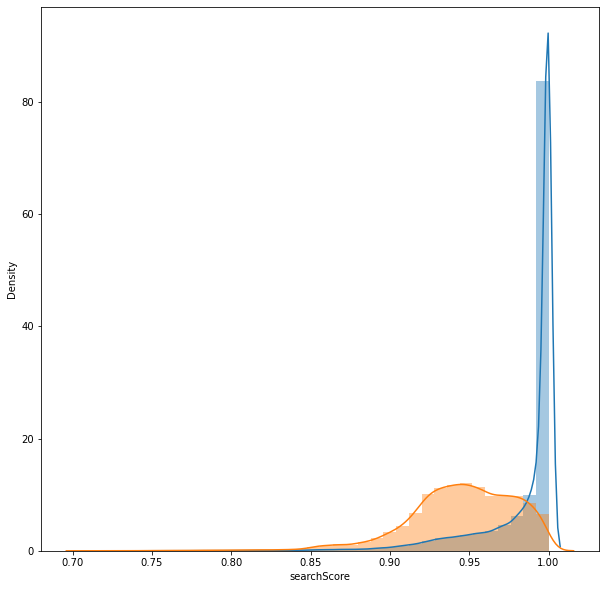

In [319]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

targets = peps_df.loc[peps_df.proteins.str.contains("DECOY") == False]
decoys = peps_df.loc[peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

<AxesSubplot:ylabel='Sample'>

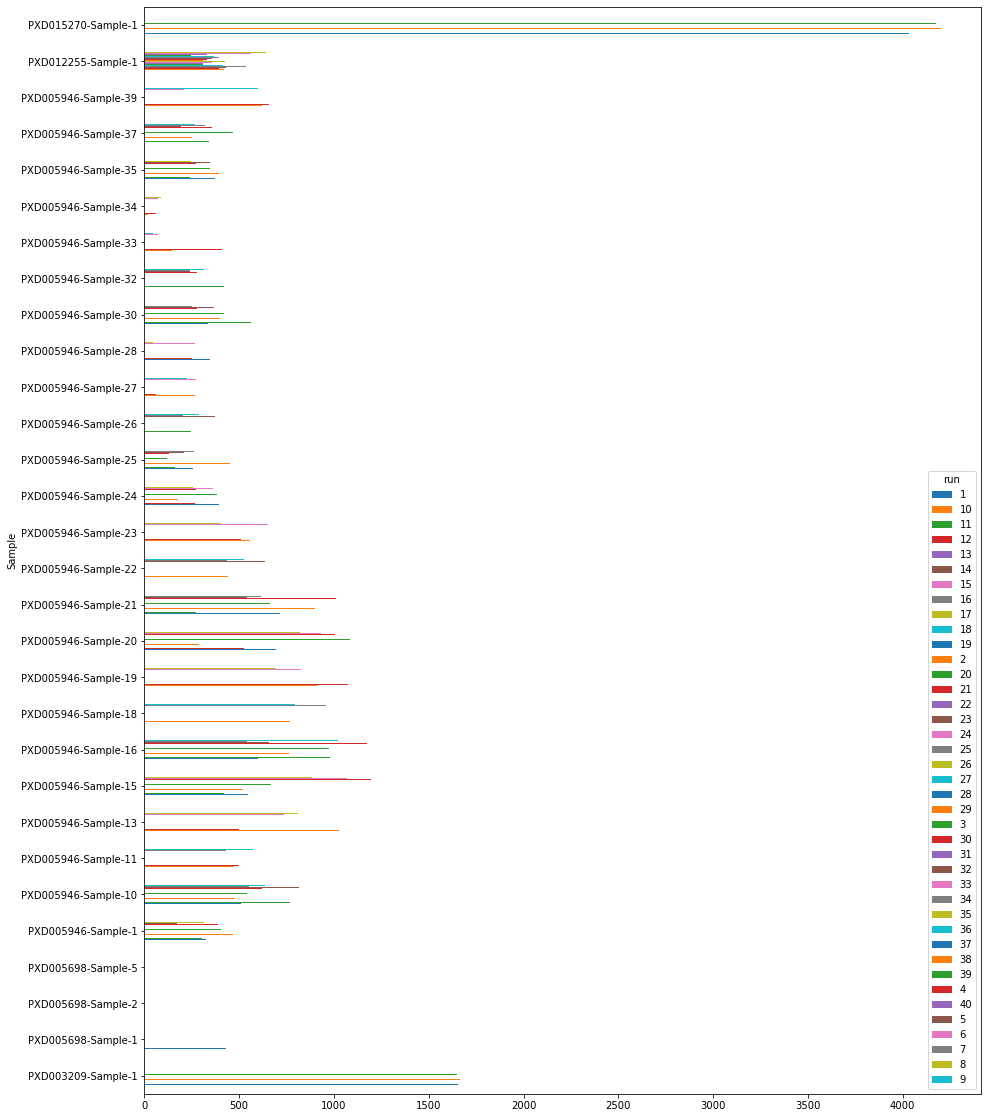

In [320]:
# Print the number of peptides per Sample and ms-run. 

plt.rcParams["figure.figsize"] = [15, 20]
targets.groupby('run').Sample.value_counts().unstack(0).plot.barh()

In [321]:
#manually wrote uniprot IDs from the contaminate db to a txt file, load to a list to filter out
conatm_ids = '|'.join([x.strip() for x in open('contam_ids.txt', 'r').readlines()])

In [340]:
conditions = [(targets['proteins'].str.contains("ENSP") & ~targets['proteins'].str.contains(conatm_ids)),
        (~(targets['proteins'].str.contains("ENSP")|targets['proteins'].str.contains(conatm_ids))
         & targets['proteins'].str.contains(r"altorf_|pseudo_|ncRNA_")),
        (~(targets['proteins'].str.contains(r"ENSP|altorf_|pseudo_|ncRNA_") | targets['proteins'].str.contains(conatm_ids))
         & targets['proteins'].str.contains(r"COSMIC|cbio")),
        (targets['proteins'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','conatminate']
targets['Class'] = np.select(conditions, classes)
targets['Class'].value_counts()

<ipython-input-340-289d11b49859>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['Class'] = np.select(conditions, classes)


canonical        145150
non_canonical     12982
conatminate        9056
variant             105
Name: Class, dtype: int64

<AxesSubplot:xlabel='Sample'>

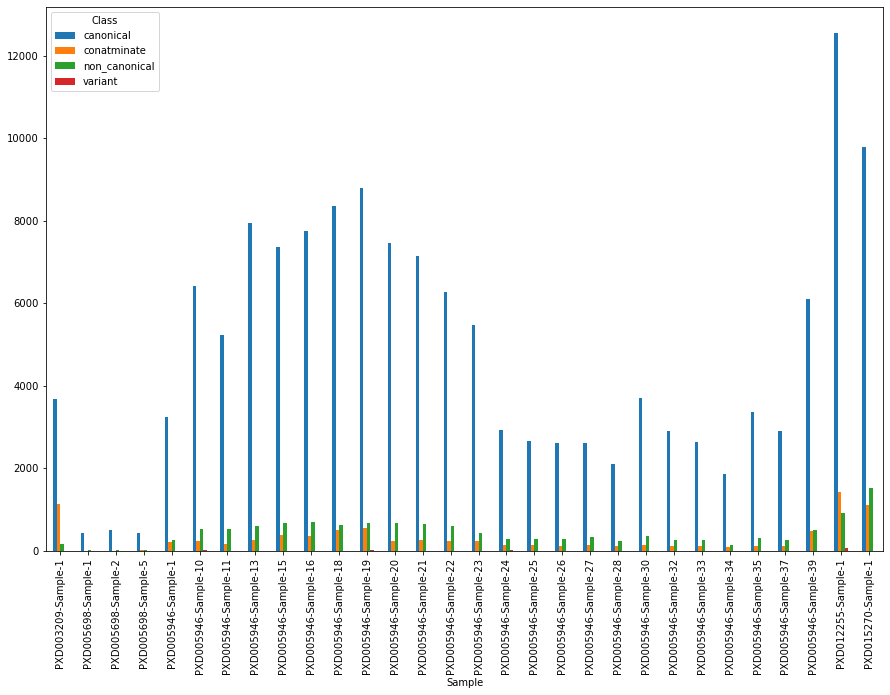

In [341]:
plt.rcParams["figure.figsize"] = [15, 10]
targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [342]:
targets.to_csv(output_file, sep='\t', index=False)

In [343]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [344]:
noncan_targets = targets[targets['Class'].str.contains(r"variant|non_canonical")==True]
noncan_seqs = list(set([rep(x) for x in noncan_targets['peptide'].tolist()]))

In [326]:
#get all canonical sequences from fasta
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))

In [327]:
#get non-canonical peptides that are found in canonical proteins
found_peps = []
auto = ahocorasick.Automaton()
for substr in noncan_seqs:
    auto.add_word(substr, substr)
auto.make_automaton()
for astr in allcan_seqs:
    for end_ind, found in auto.iter(astr):
        found_peps.append(found)

In [345]:
noncan_targets = noncan_targets[noncan_targets['peptide'].apply(rep).isin(found_peps)==False]

<AxesSubplot:xlabel='Sample'>

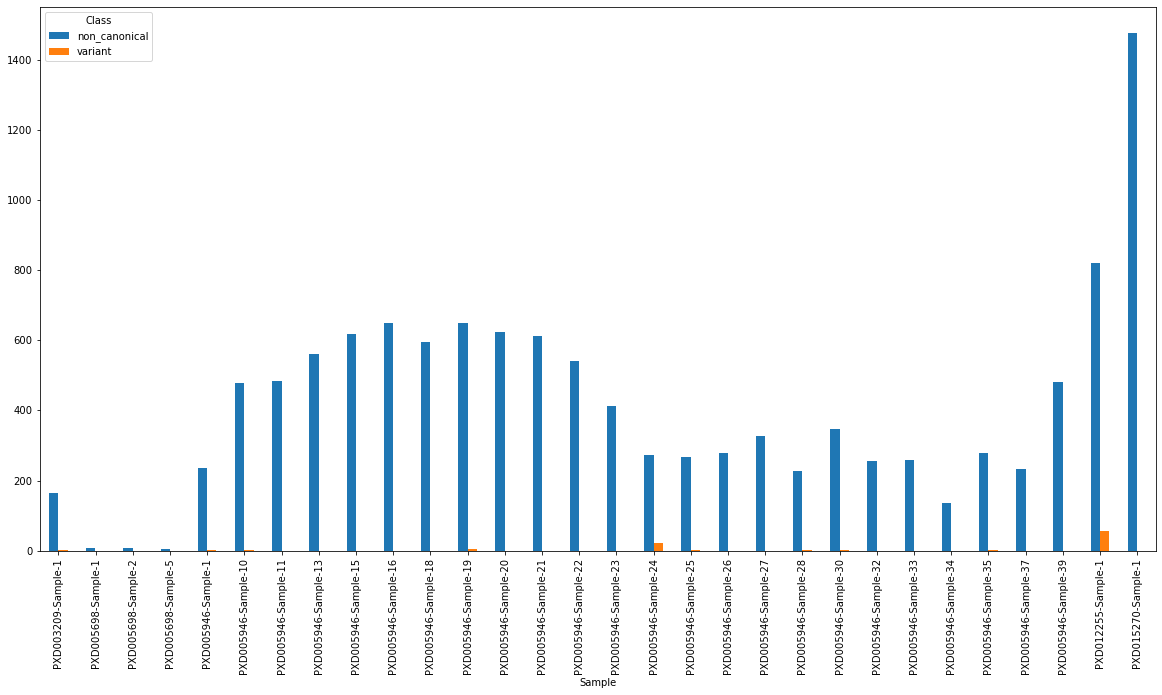

In [346]:
plt.rcParams["figure.figsize"] = [20, 10]
noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()